# Fine Tuning BERT 
# By Ahmed Essam 

## Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import warnings
from wordcloud import WordCloud
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer,TFBertModel


warnings.filterwarnings('ignore')

In [2]:

df= pd.read_csv('Data.csv')
df.head()

,UserId,TweetId,Tweet,ADR_label
0,10030778,413205,Intravenous azithromycin-induced ototoxicity.,1
1,10048291,528244,"Immobilization, while Paget's bone disease was...",1
2,10048291,361834,Unaccountable severe hypercalcemia in a patien...,1
3,10082597,292240,METHODS: We report two cases of pseudoporphyri...,1
4,10082597,467101,METHODS: We report two cases of pseudoporphyri...,1


In [3]:
df['ADR_label'].nunique()

2

In [4]:
value = df['ADR_label'].value_counts()

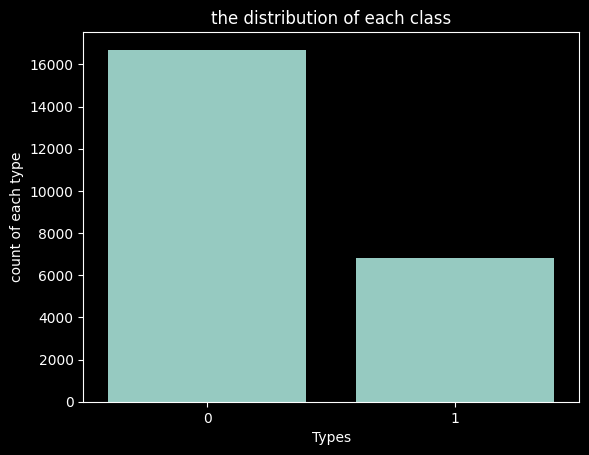

In [5]:
plt.style.use(style='dark_background')
sns.barplot(
    x=value.index, y=value.values)
plt.xlabel('Types')
plt.ylabel('count of each type')
plt.title('the distribution of each class')
plt.show()

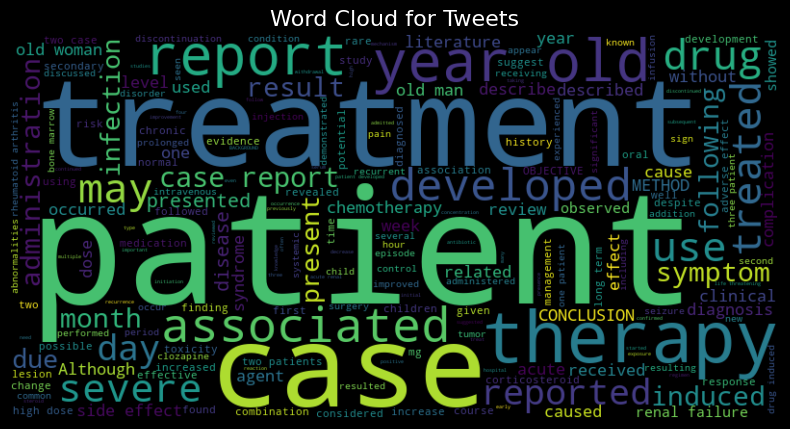

In [7]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Tweets", fontsize=16)
plt.show()

In [8]:
df['num_words'] = df.Tweet.apply(lambda x:len(x.split()))

In [9]:
df['num_words'].max()

135

In [10]:
df['ADR_label']= df['ADR_label'].astype('category')

In [11]:
data_train,data_test = train_test_split(df, test_size = 0.3, random_state = 42)

In [12]:
to_categorical(data_train.ADR_label)

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

## BERT Model

In [13]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [14]:
tokenizer.save_pretrained('bert-tokenizer')
bert.save_pretrained('bert-model')

In [15]:
tokenizer('hello this me abhishek')

{'input_ids': [101, 19082, 1142, 1143, 170, 1830, 27516, 4638, 1377, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [16]:
# Tokenize the input (takes some time) 
# here tokenizer using from bert-base-cased
x_train = tokenizer(
    text=data_train.Tweet.tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


x_test = tokenizer(
    text=data_test.Tweet.tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [17]:
import tensorflow as tf
from keras.layers import Input, Dense, Layer
from transformers import TFBertModel

max_len = 100 

bert = TFBertModel.from_pretrained("bert-base-uncased")

class BertLayer(Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

bert_outputs = BertLayer(bert)([input_ids, attention_mask])

out = tf.keras.layers.GlobalMaxPool1D()(bert_outputs)
out = Dense(256, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(128, activation='relu')(out)

y = Dense(2, activation='softmax')(out)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=y)

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer          │ (None, 100, 768)  │          0 │ input_ids[0][0],  │
│ (BertLayer)         │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 768)       │          0 │ bert_layer[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    196,864 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        258 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 230,018 (898.51 KB)

 Trainable params: 230,018 (898.51 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.layers[2].trainable = True

In [19]:
optimizer = Adam(
    learning_rate=5e-05, 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)


loss =CategoricalCrossentropy(from_logits = True)

model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = ['accuracy'])

In [20]:
model.layers

[<InputLayer name=input_ids, built=True>,
 <InputLayer name=attention_mask, built=True>,
 <BertLayer name=bert_layer, built=True>,
 <GlobalMaxPooling1D name=global_max_pooling1d, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [21]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = to_categorical(data_train.ADR_label),
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, to_categorical(data_test.ADR_label)
    ),
  epochs=3,
    batch_size=32
)

Epoch 1/3
515/515 ━━━━━━━━━━━━━━━━━━━━ 2097s 4s/step - accuracy: 0.6957 - loss: 0.6023 - val_accuracy: 0.7121 - val_loss: 0.5916
Epoch 2/3
515/515 ━━━━━━━━━━━━━━━━━━━━ 3976s 8s/step - accuracy: 0.7127 - loss: 0.5897 - val_accuracy: 0.7116 - val_loss: 0.5851
Epoch 3/3
515/515 ━━━━━━━━━━━━━━━━━━━━ 2061s 4s/step - accuracy: 0.7094 - loss: 0.5881 - val_accuracy: 0.7137 - val_loss: 0.5852


In [22]:
model.save_weights('ADR_weights..weights.h5')

In [23]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

221/221 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step


In [24]:
import numpy as np
y_predicted = np.argmax(predicted_raw, axis = 1)

In [25]:
predicted_raw[0]

array([0.75380796, 0.24619201], dtype=float32)

In [26]:
y_predicted[0]

0

In [27]:
from sklearn.metrics import classification_report


In [28]:
print(classification_report(data_test.ADR_label, y_predicted))

              precision    recall  f1-score   support

           0       0.72      0.99      0.83      5023
           1       0.58      0.02      0.04      2032

    accuracy                           0.71      7055
   macro avg       0.65      0.51      0.44      7055
weighted avg       0.68      0.71      0.60      7055



In [29]:
texts = input(str('input the text: '))

x_val = tokenizer(
    text=texts,
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True) 
validation = model.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})*100
validation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


array([[81.81064 , 18.189363]], dtype=float32)

In [30]:
encoded_dict  = {'ADR_No':0,'ADR_Yes':1}

In [31]:
for key , value in zip(encoded_dict.keys(),validation[0]):
    print(key,value)

ADR_No 81.81064
ADR_Yes 18.189363
